# Agrupamento Fuzzy

### Grupo
- Gabriel Camatta Zanotelli - 2018020140
- Nander Santos do Carmo - 2018019931

### Bibliotecas e dados

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
import math
import skfuzzy
import pandas as pd
import random as rand
import torch
from torch.utils.data import TensorDataset, DataLoader
from scipy.io import loadmat
import sys
sys.path.append("./anfis-pytorch/")
from anfispytorchmaster.experimental import train_anfis, test_anfis, plot_all_mfs
from anfispytorchmaster.membership import GaussMembFunc, make_gauss_mfs
import anfispytorchmaster.anfis as ANFIS

iris = open('Iris.csv', mode='r')
breast = open('Breast.csv', mode='r')

---
## 2- Aproximação de Funções

Utilizaremos um sistema ANFIS de tipo Tageki-Sugueno de Ordem 1 de forma a aproximar uma função na forma sen(x) definida no espaço [0,2] utilizando uma N=80 pontos utilizando a seguinte equação:

![Formula senóide com ruído](./senoide.png 'Senóide com ruído')

### Funções de Pertinência

Por experiência temos que, para representar uma senóide de forma precisa, devemos utilizar três regras de pertinência.

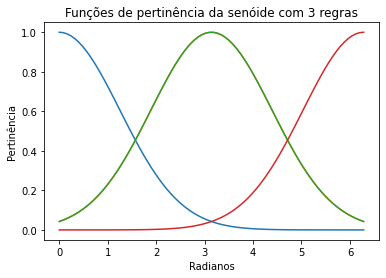

In [2]:
# Espaço definido
N = 80
x = np.linspace(0, 2*math.pi, N)

# valores de ativação de cada regra
fun_pertinencia1 = skfuzzy.gaussmf(x, 0, 1.25)
fun_pertinencia2 = skfuzzy.gaussmf(x, math.pi, 1.25)
fun_pertinencia3 = skfuzzy.gaussmf(x, 2*math.pi, 1.25)

# plota as funções de pertinência
plt.plot(x, fun_pertinencia1, x, fun_pertinencia2, x, fun_pertinencia2, x, fun_pertinencia3)
plt.title("Funções de pertinência da senóide com 3 regras")
plt.xlabel("Radianos")
plt.ylabel("Pertinência")
plt.show()

### Geração do conjunto de dados

Gera o conjunto de dados aleatórios da senóide e separa conjunto de treino e teste.

In [6]:
def gera_dados_treino(size):
    perc_train = 0.75
    x_space = np.linspace(0, 2*math.pi, size)

    # Conjunto de dados de trainamento e teste
    x_rand_id = np.linspace(0, size-1, size).astype(int)
    rand.shuffle(x_rand_id)

    x_train = x_space[x_rand_id[0:int(size*perc_train)]]
    x_te = x_space[x_rand_id[int(size*perc_train):size]]

    y = np.sin(x_space) + 0.1*np.random.randn(size)
    y_train = y[x_rand_id[0:int(size*perc_train)]]
    y_te = y[x_rand_id[int(size*perc_train):size]]

    return [x_train, x_te, y_train, y_te]


def gera_dados_modelo(x_train, y_train):
    x_train_aux = torch.tensor([[val] for val in x_train], dtype=torch.float)
    y_train_aux = torch.tensor([[val] for val in y_train], dtype=torch.float)
    return DataLoader(TensorDataset(x_train_aux, y_train_aux))

### Criação do modelo ANFIS

In [7]:
def inicializa_problema():
    x1 = [('x1', make_gauss_mfs(math.pi/2, [0.0, math.pi, 2*math.pi]))]
    x2 = ['x2']
    return ANFIS.AnfisNet('Senoide', x1, x2)

### Executa modelo

### Training for 80 epochs, training size = 60 cases
epoch    0: MSE=0.00782, RMSE=0.08845 =33.16%
epoch   10: MSE=0.00781, RMSE=0.08837 =32.95%
epoch   20: MSE=0.00779, RMSE=0.08826 =32.70%
epoch   30: MSE=0.00777, RMSE=0.08816 =32.45%
epoch   40: MSE=0.00776, RMSE=0.08807 =32.21%
epoch   50: MSE=0.00774, RMSE=0.08798 =31.97%
epoch   60: MSE=0.00773, RMSE=0.08790 =31.74%
epoch   70: MSE=0.00771, RMSE=0.08782 =31.51%


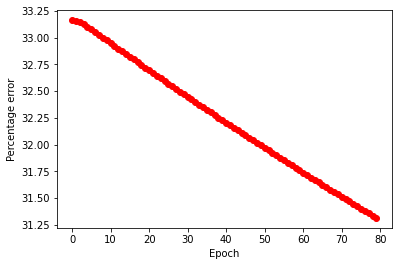

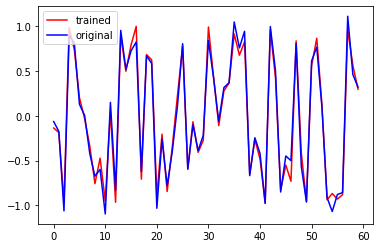

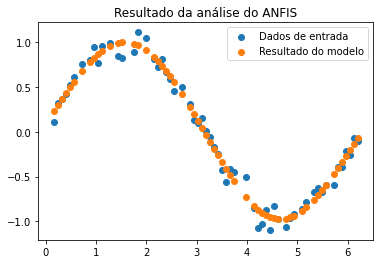

MSE: 0.004619874060153961


In [9]:
anfis_model = inicializa_problema()
dados_treino = gera_dados_treino(N)
dados_treino_modelados = gera_dados_modelo(dados_treino[0], dados_treino[2])

train_anfis(anfis_model, dados_treino_modelados, N, True)
x_result = np.ravel(dados_treino_modelados.dataset.tensors[0])
y_treino = np.ravel(dados_treino_modelados.dataset.tensors[1])
y_result = np.ravel(anfis_model(dados_treino_modelados.dataset.tensors[0]).detach().numpy())
plt.scatter(x_result, y_treino, label='Dados de entrada')
plt.scatter(x_result, y_result, label='Resultado do modelo')
plt.title("Resultado da análise do ANFIS")
plt.legend()
plt.show()

error = np.sum((y_treino - y_result)**2)/100
print("MSE: " + str(error))

---
## 3- Previsão de uma Séria Temporal

A série temporal de *Mackey-Glass* é definida pela seguinte formula:

![Série de Mackey-Glass](./serie_temporal.png 'Formato da série temporal')

### Geração dos dados modelados

In [ ]:
def gera_dados(dados):
    n = len(dados) - 18
    x = torch.zeros((n, 4))
    y = torch.zeros((n, 1))
    for t in range(18, len(dados)-6):
            aux_values = [dados[t-18], dados[t-12], dados[t-6], dados[t], dados[t+6]]
            x[t-18] = torch.tensor(aux_values[0:4])
            y[t-18] = aux_values[4]
    dl = DataLoader(TensorDataset(x, y), batch_size=1024, shuffle=True)
    return dl

### Criação do modelo ANFIS

In [ ]:
def inicializa_problema():
    x1 = [
            ('t-12', make_gauss_mfs(0.1, [0.425606, 1.313696])),
            ('t-12', make_gauss_mfs(0.1, [0.425606, 1.313696])),
            ('t-6',  make_gauss_mfs(0.1, [0.425606, 1.313696])),
            ('t',    make_gauss_mfs(0.1, [0.425606, 1.313696]))]
    x2 = ['t+6']
    return ANFIS.AnfisNet('Previsão de uma Séria Temporal', x1, x2)

### Executa modelo

In [ ]:
dados = np.ravel(loadmat('mg.mat')['x'])
N = len(dados)
dados_train = dados[0:int(N*.8)]
dados_te = dados[int(N*.8)+1:N]

modelo = inicializa_problema()
dados_treino_modelados = gera_dados(dados_train)
train_anfis(modelo, dados_treino_modelados, 100, True)

dados_teste_modelados = gera_dados(dados_te)
test_anfis(modelo, dados_teste_modelados, True)

---
## 4- Classificação de Padrões